In [24]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression

## Custom function definitions

In [25]:
def get_conditional_cdf(df, key_cond, val_cond, key_metric, lb=-40, ub=40, n_points=4000, gaussian_bw=2, do_boot=False):

    if do_boot:
        data = df.loc[ df[key_cond] == val_cond, key_metric].sample(frac=1, replace=True)
    else:
        data = df.loc[ df[key_cond] == val_cond, key_metric]

    sample = np.atleast_2d(data).T
    kde = KernelDensity(kernel="gaussian", bandwidth=gaussian_bw).fit(sample)
    xx = np.atleast_2d(np.linspace(lb,ub,n_points)).T
    yy = kde.score_samples(xx)
    kde_cdf = np.cumsum(np.exp(yy)) / np.sum(np.exp(yy))

    return kde_cdf, xx, yy, sample

def get_quantiles_from_cdf(cdf,xx,yq):
    # xx is the entire cdf x axis
    # yq is a list of the quantiles that you want eg. [0.47,0.5,0.53]
    vals=[]
    inds=[]
    for q in yq:
        idx = np.argmin(np.abs(cdf-q))
        vals.append(xx[idx])
        inds.append(idx)
    return vals, inds

def my_ci(x):
    # return 95% confidence interval of vector x
    # x has been loaded with bootstrapped values, for example
    return (np.quantile(x,0.025), np.quantile(x,0.975))

def stylize_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

## Specify the options of the analysis

In [26]:
n_boots=100 # number of bootstrap resamples -- large values will slow down execution
## Note 1: the figures in the paper use n_boots=1000 (setting to 100 here to make things run faster)
## Note 2: due to the randomness in bootstrap resampling, the results are stochastic
offsets = [-3,-2,-1,0,1,2,3] # hypothetical deviations from true median
mincount=100 # minimum number of games in each stratification required to be retained for analysis
gaussian_bw=2 # bandwidth parameter in kernel density estimation (used to deal with discreteness of margin)
phi=100/110 # nominal profit on a unit bet

## Read the curated data

In [27]:
dfo = pd.read_csv('../data/nfl_data.csv')

## Define the set of unique point spreads and point totals

In [28]:
unq_spreads = np.unique(dfo.sportsbook_spread)
unq_totals = np.unique(dfo.sportsbook_total)

## Build dataframes for analysis of margin of victory

In [29]:
kde_ev=np.nan * np.ones(shape=(len(unq_spreads),n_boots,len(offsets)))
dict_margin = [] # stores summary statistics: median + other quantiles
dict_margin_raw = [] # stores each record on its own dataframe row

for idx_s, spread in enumerate(unq_spreads):

    for b in range(n_boots):
        kde_cdf, xx, yy, sample = get_conditional_cdf(dfo,'sportsbook_spread',spread,'true_margin',-40,40,4000,gaussian_bw, do_boot=True)

        tvals,tinds = get_quantiles_from_cdf(kde_cdf,xx,[phi/(1+phi),0.5,1/(1+phi)])

        # measure expected value as a function of offset
        # now across bootstrap samples
        for idx_o,offset in enumerate(offsets):
            tidx = np.argmin(np.abs(xx - (xx[tinds[1]] + offset)))
            Fmm = kde_cdf[tidx]
            ev_bh = Fmm*phi - (1-Fmm)
            ev_bv = (1-Fmm)*phi - Fmm
            ev_max = np.max((ev_bh,ev_bv))
            kde_ev[idx_s,b,idx_o] = ev_max

            dict_margin_raw.append(
            {
                'idx_offset':tidx,
                'offset': offset,
                'bootidx': b,
                'spread': spread,
                'ev': ev_max
            }
            )

        dict_margin.append(
            {
                'q47': tvals[0][0],
                'median': tvals[1][0],
                'q53': tvals[2][0],
                'count': np.sum(dfo['sportsbook_spread']==spread),
                'spread': spread,
                'ev': kde_ev[idx_s,b,:],
                'bootidx': b
            }
        )

df_margin = pd.DataFrame(dict_margin)
df_margin=df_margin.set_index('spread')

df_margin_raw = pd.DataFrame(dict_margin_raw)

## Split expected value into separate columns

In [30]:
df_tmp = df_margin.ev.apply(pd.Series)
df_tmp.columns = ['-3','-2','-1','0','1','2','3']
df_margin=pd.concat((df_margin,df_tmp),axis=1)
df_margin=df_margin.drop('ev',axis=1)

for key,val in df_margin.items():
        try:
            df_margin[key]=df_margin[key].str[0]
        except:
            pass

## Build dataframe for analysis of point totals

In [31]:
kde_total_ev=np.nan * np.ones(shape=(len(unq_totals),n_boots,len(offsets)))
dict_total = []
dict_total_raw = []

for idx_t, total in enumerate(unq_totals):

    for b in range(n_boots):
        kde_cdf, xx, yy, _ = get_conditional_cdf(dfo,'sportsbook_total',total,'true_total',10,90,4000,gaussian_bw, do_boot=True)
        tvals,tinds = get_quantiles_from_cdf(kde_cdf,xx,[0.47,0.5,0.53])

        for idx_o,offset in enumerate(offsets):
            tidx = np.argmin(np.abs(xx - (xx[tinds[1]] + offset)))
            Fmm = kde_cdf[tidx]
            ev_bo = Fmm*phi - (1-Fmm)
            ev_bu = (1-Fmm)*phi - Fmm
            ev_max = np.max((ev_bo,ev_bu))
            kde_total_ev[idx_t,b,idx_o] = ev_max

            dict_total_raw.append(
            {
                'idx_offset':tidx,
                'offset': offset,
                'bootidx': b,
                'total': total,
                'ev': ev_max
            }
            )

        dict_total.append(
            {
                'q47': tvals[0],
                'median': tvals[1],
                'q53': tvals[2],
                'count': np.sum(dfo['sportsbook_total']==total),
                'total': total,
                'ev': kde_total_ev[idx_t,b,:],
                'bootidx': b
            }
        )
df_total = pd.DataFrame(dict_total)
df_total = df_total.set_index('total')

df_total_raw = pd.DataFrame(dict_total_raw)

## Repeat splitting of expected value for totals

In [32]:
df_tmp = df_total.ev.apply(pd.Series)
df_tmp.columns = ['-3','-2','-1','0','1','2','3']
df_total=pd.concat((df_total,df_tmp),axis=1)
df_total = df_total.drop('ev',axis=1)

for key,val in df_total.items():
    try:
        df_total[key]=df_total[key].str[0]
    except:
        pass

total_rows_to_show= (df_total['count']>mincount)
total_n_to_show=np.sum(total_rows_to_show)

## Identify which stratifications have enough games

In [33]:
has_enough_samples_margin = df_margin['count']>mincount
valid_spreads = np.unique(df_margin[has_enough_samples_margin].index)

has_enough_samples_total = df_total['count']>mincount
valid_totals = np.unique(df_total[has_enough_samples_total].index)

## Construct 95\% confidence intervals for margin of victory

In [34]:
df_margin_ci = df_margin.loc[:,['q47','median','q53','-3','-2','-1','0','1','2','3']].groupby('spread').quantile((0.025,0.975))
df_margin_ci = df_margin_ci.loc[valid_spreads,:]
df_margin_ci['is_below_47'] = df_margin_ci.apply(lambda x: x['q47'] > x.name[0] if x.name[1]==0.025 else False, axis=1 )
df_margin_ci['is_above_53'] = df_margin_ci.apply(lambda x: x['q53'] < x.name[0] if x.name[1]==0.975 else False, axis=1 )
df_margin_ci['is_sig'] = df_margin_ci['is_below_47'] | df_margin_ci['is_above_53']

df_margin_ci_lo = df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.025,:]
df_margin_ci_hi = df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.975,:]

ci_width_47_m = df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.975,'q47'].to_numpy() - df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.025,'q47'].to_numpy()

ci_width_53_m = df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.975,'q53'].to_numpy() - df_margin_ci.loc[df_margin_ci.index.get_level_values(None) == 0.025,'q53'].to_numpy()

## Construct 95\% confidence intervals for point totals

In [35]:
df_total_ci = df_total.loc[:, ['q47', 'median', 'q53', '-3', '-2', '-1', '0', '1', '2', '3']].groupby('total').quantile(
    (0.025, 0.975))
df_total_ci = df_total_ci.loc[valid_totals, :]
df_total_ci['is_below_47'] = df_total_ci.apply(lambda x: x['q47'] > x.name[0] if x.name[1] == 0.025 else False, axis=1)
df_total_ci['is_above_53'] = df_total_ci.apply(lambda x: x['q53'] < x.name[0] if x.name[1] == 0.975 else False, axis=1)

df_total_ci['is_sig'] = df_total_ci['is_below_47'] | df_total_ci['is_above_53']
df_total_ci_lo = df_total_ci.loc[df_total_ci.index.get_level_values(None) == 0.025, :]
df_total_ci_hi = df_total_ci.loc[df_total_ci.index.get_level_values(None) == 0.975, :]

ci_width_47_t = df_total_ci.loc[df_total_ci.index.get_level_values(None) == 0.975, 'q47'].to_numpy() - df_total_ci.loc[
    df_total_ci.index.get_level_values(None) == 0.025, 'q47'].to_numpy()

ci_width_53_t = df_total_ci.loc[df_total_ci.index.get_level_values(None) == 0.975, 'q53'].to_numpy() - df_total_ci.loc[
    df_total_ci.index.get_level_values(None) == 0.025, 'q53'].to_numpy()

## Regress sportsbook point spread onto empirical median margin of victory

In [36]:
df_margin = df_margin.reset_index()

df_group = df_margin[df_margin.spread.isin(valid_spreads)].groupby('bootidx')['spread', 'median']
df_margin_reg = pd.DataFrame()
for group in df_group.groups.keys():
    df = df_group.get_group(group)
    X = np.array(df[['spread']])
    y = np.array(df[['median']])
    model = LinearRegression().fit(X, y)
    df_margin_reg.loc[group, ['slope']] = model.coef_[0][0]
    df_margin_reg.loc[group, ['intercept']] = model.intercept_[0]
    df_margin_reg.loc[group, ['r2']] = model.score(X, y)

df_margin_reg_mean = df_margin_reg.mean(axis=0)
df_margin_reg_lo = df_margin_reg.quantile(0.025)
df_margin_reg_hi = df_margin_reg.quantile(0.975)

a_m = df_margin_reg_mean['slope']
b_m = df_margin_reg_mean['intercept']
r_squared_m = df_margin_reg_mean['r2']

df_margin=df_margin.set_index('spread')

/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_31210/2590896136.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_group = df_margin[df_margin.spread.isin(valid_spreads)].groupby('bootidx')['spread', 'median']


## Regress sportsbook point total onto empirical median point total

In [37]:
df_total = df_total.reset_index()

df_group = df_total[df_total.total.isin(valid_totals)].groupby('bootidx')['total', 'median']
df_total_reg = pd.DataFrame()
for group in df_group.groups.keys():
    df = df_group.get_group(group)
    X = np.array(df[['total']])
    y = np.array(df[['median']])
    model = LinearRegression().fit(X, y)
    df_total_reg.loc[group, ['slope']] = model.coef_[0][0]
    df_total_reg.loc[group, ['intercept']] = model.intercept_[0]
    df_total_reg.loc[group, ['r2']] = model.score(X, y)

df_total_reg_mean = df_total_reg.mean(axis=0)
df_total_reg_lo = df_total_reg.quantile(0.025)
df_total_reg_hi = df_total_reg.quantile(0.975)

a_t = df_total_reg_mean['slope']
b_t = df_total_reg_mean['intercept']
r_squared_t = df_total_reg_mean['r2']

a_t, b_t, r_squared_t

df_total = df_total.set_index('total')

/var/folders/rr/jrb2ds1j2pj23dsv9x3lk9y00000gn/T/ipykernel_31210/733984102.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_group = df_total[df_total.total.isin(valid_totals)].groupby('bootidx')['total', 'median']


## Compute mean values across _bootstrap resamples_

In [38]:
df_margin_mu = df_margin.loc[valid_spreads,['q47','median','q53','-3','-2','-1','0','1','2','3']].groupby('spread').mean()
df_total_mu = df_total.loc[valid_totals,['q47','median','q53','-3','-2','-1','0','1','2','3']].groupby('total').mean()

## Combine mean values with confidence intervals

In [39]:
df_margin_mu['level'] = 'Mean'
df_margin_mu.set_index('level', append=True, inplace=True)
df_margin_cat = pd.concat((df_margin_mu, df_margin_ci), axis=0)
df_margin_cat = df_margin_cat.sort_index()

df_total_mu['level'] = 'Mean'
df_total_mu.set_index('level', append=True, inplace=True)
df_total_cat = pd.concat((df_total_mu, df_total_ci), axis=0)
df_total_cat = df_total_cat.sort_index()

## Compute grand means (relevant for expected values)

In [40]:
grand_mus_margin = df_margin_mu.mean(axis=0)
grand_sigmas_margin = df_margin_mu.std(axis=0)

grand_mus_total = df_total_mu.mean(axis=0)
grand_sigmas_total = df_total_mu.std(axis=0)

## Make a copy of dataframe that only contains the stratifications with enough samples

In [41]:
df_margin_raw_filt = df_margin_raw.loc[df_margin_raw.spread.isin(valid_spreads),:]
df_total_raw_filt = df_total_raw.loc[df_total_raw.total.isin(valid_totals),:]

# Figure 1
## Compare sportsbook against empirical median

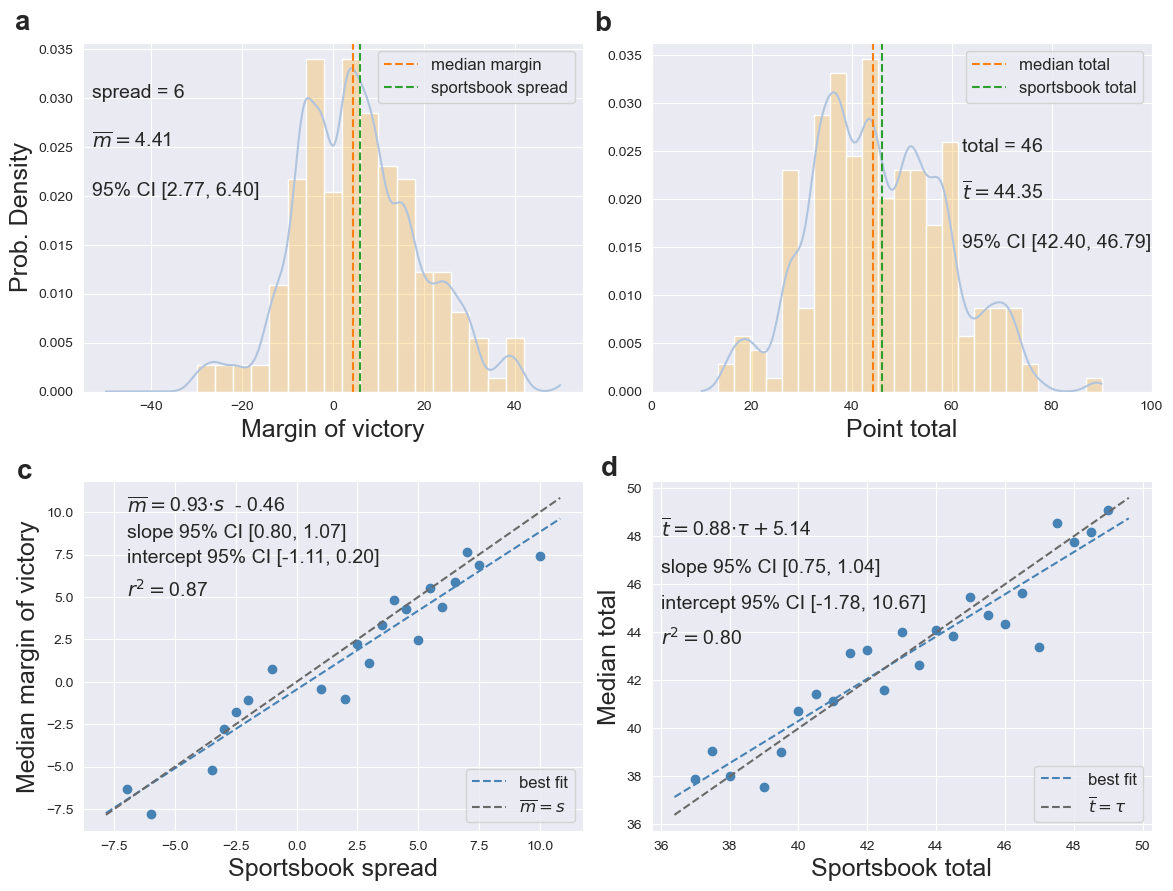

In [42]:
# data for kde plot of one stratified sample of margins (here so=6)
so=6
mdnm=df_margin_mu.loc[so,'median'].to_numpy()[0]
kde_cdfm, xxm, yym, smpm = get_conditional_cdf(dfo,'sportsbook_spread',so,'true_margin',-50,50,5000,gaussian_bw)

# data for kde plot of one stratified sample of totals
to=46
mdnt=df_total_mu.loc[to,'median'].to_numpy()[0]
kde_cdft, xxt, yyt, smpt = get_conditional_cdf(dfo,'sportsbook_total',to,'true_total',10,90,5000,gaussian_bw)

lgfs=12

fig,ax = plt.subplots(2,2,figsize=(12,9))
ax[0,0].plot(xxm,np.exp(yym),color='lightsteelblue')
ax[0,0].hist(smpm,bins=25,density=True,range=[-50,50],fc=(255/255,165/255,0/255,0.25))
#fc=(255/255,87/255,51/255,0.25)
yl=ax[0,0].get_ylim()
ax[0,0].plot([mdnm, mdnm],yl, label='median margin', ls='--')
ax[0,0].plot([so, so],yl, label='sportsbook spread', ls='--')
ax[0,0].legend(loc='upper right',fontsize=lgfs)
ax[0,0].set_ylim(yl)
ax[0,0].set_ylabel('Prob. Density', fontdict={'family':'sans-serif','size':18})
ax[0,0].set_xlabel('Margin of victory', fontdict={'family':'sans-serif','size':18})
ax[0,0].text(-53, 0.025, '$\overline{m} = $' + "{:.2f}".format(mdnm)  , fontsize = 14)
ax[0,0].text(-53, 0.03, 'spread = ' + "{:.0f}".format(so), fontsize = 14)
ax[0,0].text(-53, 0.02, '95% CI [' + "{:.2f}".format(df_margin_ci.loc[(so,0.025),'median'])
             + ", {:.2f}".format(df_margin_ci.loc[(so,0.975),'median']) + ']', fontsize = 14)
ax[0,0].text(-70,0.037,'a', fontdict={'family':'sans-serif','size':20,'weight':'bold'} )

ax[0,1].plot(xxt,np.exp(yyt),color='lightsteelblue')
ax[0,1].hist(smpt,bins=25,density=True,range=[10,90],fc=(255/255,165/255,0/255,0.25))
yl=ax[0,1].get_ylim()
ax[0,1].plot([mdnt, mdnt],yl, label='median total', ls='--')
ax[0,1].plot([to, to],yl, label='sportsbook total', ls='--')
ax[0,1].legend(loc='upper right', fontsize=lgfs)
ax[0,1].set_ylim(yl)
ax[0,1].set_xlim((0,100))
#ax[0,1].set_ylabel('Prob. Density', fontdict={'family':'sans-serif','size':18})
ax[0,1].set_xlabel('Point total', fontdict={'family':'sans-serif','size':18})
ax[0,1].text(62, 0.025, r'total = ' + "{:.0f}".format(to), fontsize = 14)
ax[0,1].text(62, 0.02, '$\overline{t} = $' + "{:.2f}".format(mdnt)  , fontsize = 14)
ax[0,1].text(62, 0.015, '95% CI [' + "{:.2f}".format(df_total_ci.loc[(to,0.025),'median'])
             + ", {:.2f}".format(df_total_ci.loc[(to,0.975),'median']) + ']', fontsize = 14)
ax[0,1].text(-11.5,0.0375,'b', fontdict={'family':'sans-serif','size':20,'weight':'bold'} )


ax[1,0].plot(valid_spreads,df_margin_mu['median'],'o',color='steelblue')
xax = np.array(ax[1,0].get_xlim())
ax[1,0].plot(xax, a_m*xax+b_m,'--',color='steelblue', label='best fit')
ax[1,0].plot(xax, xax,'--',color='dimgray', label='$\overline{m}=s$')
stylize_axes(ax[1,0])
ax[1,0].set_ylabel('Median margin of victory', fontdict={'family':'sans-serif','size':18})
ax[1,0].set_xlabel('Sportsbook spread', fontdict={'family':'sans-serif','size':18})
ax[1,0].text(-7, 10, '$\overline{m} = $' + "{:.2f}".format(a_m) + "$\cdot s$  - {:.2f}".format(np.abs(b_m))  , fontsize = 14)

ax[1,0].text(-7, 8.5, 'slope 95% CI [' + "{:.2f}".format(df_margin_reg_lo['slope'] )
             + ", {:.2f}".format(df_margin_reg_hi['slope']) + ']', fontsize = 14)
ax[1,0].text(-7, 7, 'intercept 95% CI [' + "{:.2f}".format(df_margin_reg_lo['intercept'] )
             + ", {:.2f}".format(df_margin_reg_hi['intercept']) + ']', fontsize = 14)

ax[1,0].text(-7, 5, '$r^2 = $' + "{:.2f}".format(r_squared_m), fontsize = 14)

ax[1,0].legend(loc='lower right',fontsize=lgfs)
ax[1,0].text(-11.5,12,'c', fontdict={'family':'sans-serif','size':20,'weight':'bold'} )

ax[1,1].plot(valid_totals,df_total_mu['median'],'o',color='steelblue')
xax = np.array(ax[1,1].get_xlim())
ax[1,1].plot(xax, a_t*xax+b_t,'--',color='steelblue', label='best fit')
ax[1,1].plot(xax, xax,'--',color='dimgray', label='$\overline{t}= $' +  r'$\tau$')
stylize_axes(ax[1,1])
ax[1,1].set_ylabel('Median total', fontdict={'family':'sans-serif','size':18})
ax[1,1].set_xlabel('Sportsbook total', fontdict={'family':'sans-serif','size':18})
ax[1,1].text(36, 48, '$\overline{t} = $' + "{:.2f}".format(a_t) + '$\cdot$' + r'$\tau + $' + "{:.2f}".format(np.abs(b_t))  , fontsize = 14)

ax[1,1].text(36, 46.5, 'slope 95% CI [' + "{:.2f}".format(df_total_reg_lo['slope'] )
             + ", {:.2f}".format(df_total_reg_hi['slope']) + ']', fontsize = 14)
ax[1,1].text(36, 45, 'intercept 95% CI [' + "{:.2f}".format(df_total_reg_lo['intercept'] )
             + ", {:.2f}".format(df_total_reg_hi['intercept']) + ']', fontsize = 14)

ax[1,1].text(36, 43.5, '$r^2 = $' + "{:.2f}".format(r_squared_t), fontsize = 14)
ax[1,1].legend(loc='lower right',fontsize=lgfs)
ax[1,1].text(34.25,50.5,'d', fontdict={'family':'sans-serif','size':20,'weight':'bold'} )

fig.tight_layout()
plt.show()

# Figure 2
## Sportsbook point spread versus empirical margin of victory, shown for each stratification

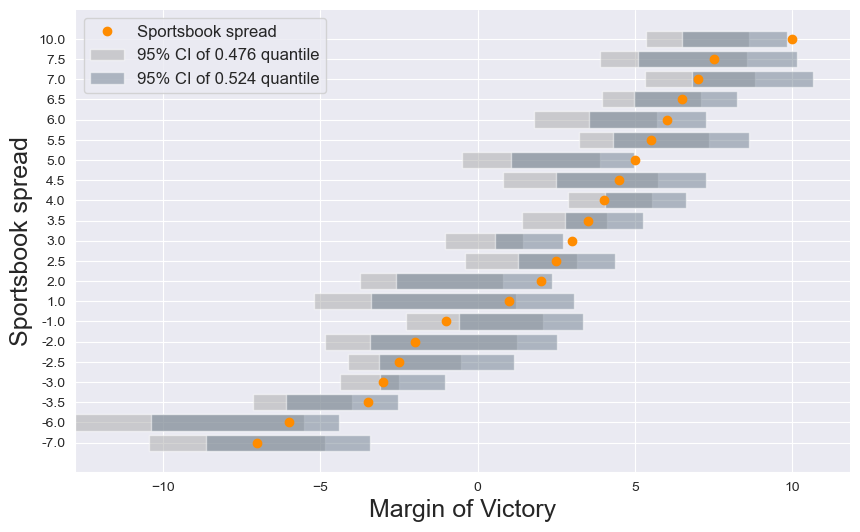

In [43]:
fig, ax = plt.subplots(1,figsize=(10,6))

xticks = np.arange(len(valid_spreads))
xticklabels = valid_spreads

# show 95% CI for 47th percentile (percentiles of percentiles!)
hb_47=ax.barh(xticks, ci_width_47_m, left=df_margin_ci_lo['q47'], color='darkgrey', label='95% CI of 0.476 quantile', alpha=0.5)
hb_53=ax.barh(xticks, ci_width_53_m, left=df_margin_ci_lo['q53'], color='slategrey', label='95% CI of 0.524 quantile', alpha=0.5)
hp=ax.plot(valid_spreads,xticks,'o', label='Sportsbook spread', color='darkorange')
xtck=ax.get_xticks()
ax.set_yticks(xticks)
ax.set_yticklabels(xticklabels)
stylize_axes(ax)
ax.set_ylabel('Sportsbook spread', fontdict={'family':'sans-serif','size':18})
ax.set_xlabel('Margin of Victory', fontdict={'family':'sans-serif','size':18})
ax.legend(fontsize=lgfs)

plt.show()
fig.tight_layout()

# Figure 3
## Sportsbook point total versus empirical total, shown for each stratification

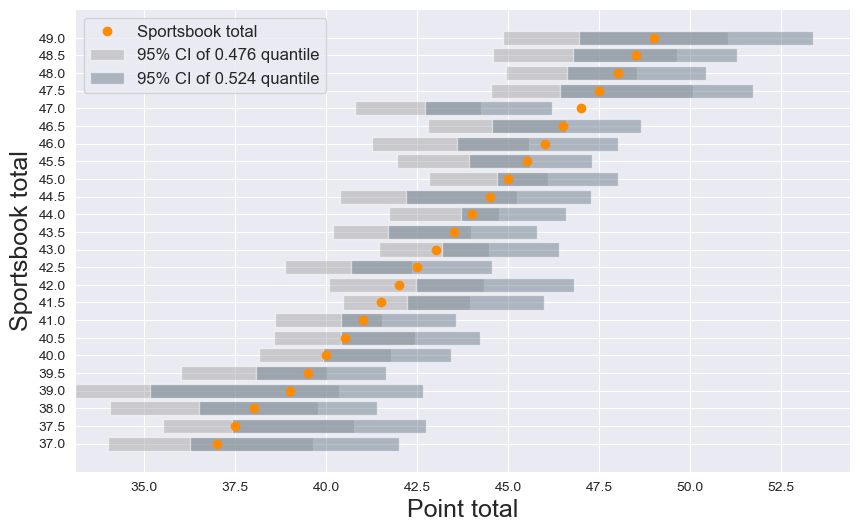

In [44]:
fig, ax = plt.subplots(1,figsize=(10,6))

xticks = np.arange(len(valid_totals))
xticklabels = valid_totals

# show 95% CI for 47th percentile (percentiles of percentiles!)
hb_47=ax.barh(xticks, ci_width_47_t, left=df_total_ci_lo['q47'], color='darkgrey', label='95% CI of 0.476 quantile', alpha=0.5)
hb_53=ax.barh(xticks, ci_width_53_t, left=df_total_ci_lo['q53'], color='slategrey', label='95% CI of 0.524 quantile', alpha=0.5)
hp=ax.plot(valid_totals,xticks,'o', label='Sportsbook total', color='darkorange')
xtck=ax.get_xticks()
ax.set_yticks(xticks)
ax.set_yticklabels(xticklabels)
stylize_axes(ax)
ax.set_ylabel('Sportsbook total', fontdict={'family':'sans-serif','size':18})
ax.set_xlabel('Point total', fontdict={'family':'sans-serif','size':18})
ax.legend(fontsize=lgfs)
#ax.text(-10.5,19.5,'a', fontdict={'family':'sans-serif','size':20,'weight':'bold'} )

plt.show()
fig.tight_layout()

# Figure 4
## Expected profit as a function of sportsbook error in setting point spread

Text(0, 0.5, 'Expected profit on unit bet')

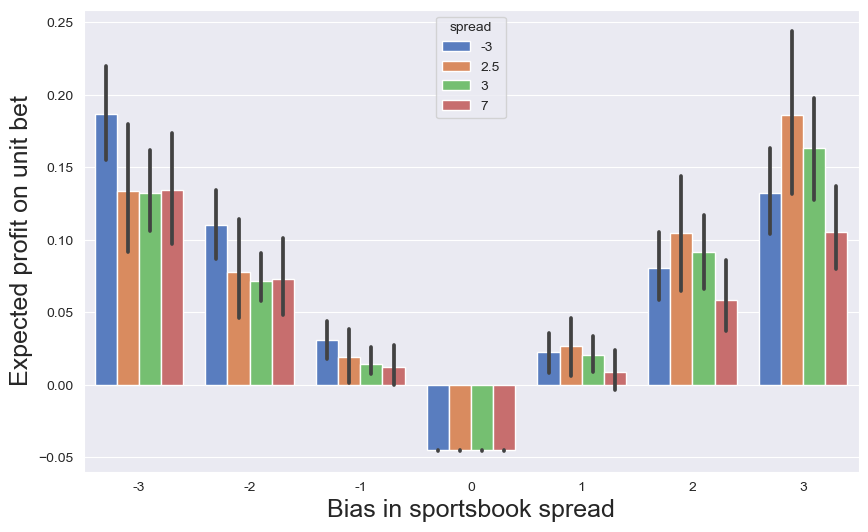

In [45]:
fig, ax = plt.subplots(1,figsize=(10,6))
ax=sns.barplot(data=df_margin_raw_filt, x="offset", y="ev", hue="spread", hue_order=[-3,2.5,3,7], errorbar=my_ci, palette="muted")

ax.set_xlabel('Bias in sportsbook spread', fontdict={'family':'sans-serif','size':18})
ax.set_ylabel('Expected profit on unit bet', fontdict={'family':'sans-serif','size':18})

# Figure 5
## Expected profit as a function of sportsbook error in setting point total

Text(0, 0.5, 'Expected profit on unit bet')

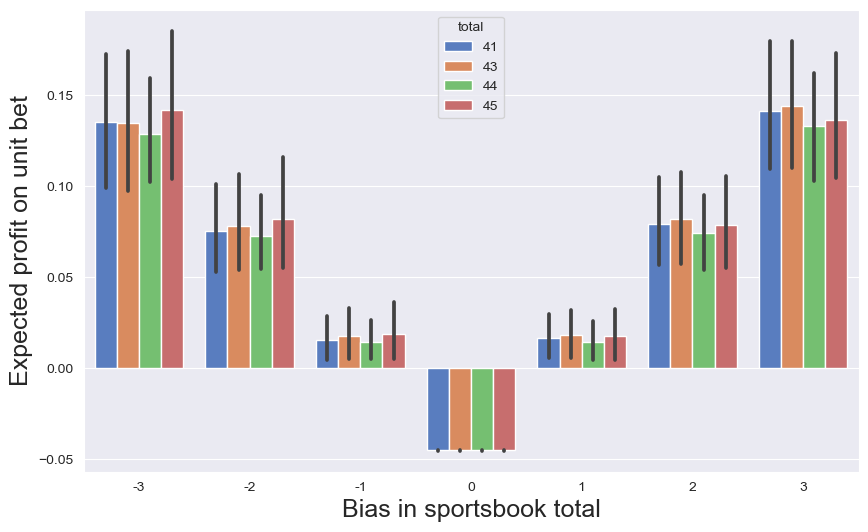

In [46]:
fig, ax = plt.subplots(1,figsize=(10,6))

ax=sns.barplot(data=df_total_raw_filt, x="offset", y="ev", hue="total", hue_order=[41,43,44,45], errorbar=my_ci, palette="muted")

ax.set_xlabel('Bias in sportsbook total', fontdict={'family':'sans-serif','size':18})
ax.set_ylabel('Expected profit on unit bet', fontdict={'family':'sans-serif','size':18})